In [1]:
import numpy as np
from hyperopt import hp, fmin, tpe, space_eval
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [5]:
# #Open Loop
# k_tesA = np.uniform(1, 1000)
# r_lac = np.uniform(10E-11, 10E-8) 
# mu = 1.93E-4 #From toy model - find value from paper

# #Open Loop Intermediate
# r_bad = np.uniform(10E-11, 10E-8)
# k_car = 2.83E-4

# #Negative gene loop
# r_tl = 2.09E-11
# kd_tetR = 3.0E-8
# r_tl_tetR = 2.18E-11
# k_tesA = 105.25

# #Negative metabolic loop
# r_fl_prime = 1E-11 
# k_i = 0.079
# k_tesA = 77.75

# #Layered negative metabolic loop
# r_tl = 1.66E-11
# k_tesA = 230.9   
# r_ar2 = 2.21E-9
# kd_tetR = 3.85E-8
# kd_fadR_FFA = 0.001
# k2 = 138.50


4.0566215199398046e-05

In [15]:
def michaelismenten(x, vm, km):
    return (vm*x)/(km+x)

def promoteractivation(x, r, kd):
    return r/(1+(x/kd))

def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
    loss = alpha1*j1 + alpha2*j2
    return j1, j2, loss

In [16]:
def fa_openloop(t, y, ydot, params):
    FFA, tesA, j2 = y
    mu = 1.93E-4
    k_tesA = 100.
    r_lac = params
    ydot[0] = tesA*k_tesA - mu*FFA
    ydot[1] = r_lac - mu*tesA
    ydot[2] = r_lac

In [17]:
def fa_openloopintermediate(t, y, ydot, params):
    FFA, tesA, CAR, j2 = y
    mu = 1.93E-4
    k_car = 2.83E-4
    k_tesA = 100
    r_lac, r_bad = params
    ydot[0] = tesA * k_tesA - mu * FFA - CAR * k_car
    ydot[1] = r_lac - mu*tesA
    ydot[2] = r_bad - mu*CAR
    ydot[3] = r_bad + r_lac

In [18]:
def fa_negativegeneloop(t, y, ydot, params):
    FFA, tesA, tetR, j2 = y
    mu = 1.93E-4
    kd_tetR = 3.0E-8
    k_tesA = 105.25
    r_tl, r_tl_tetR = params
    ydot[0] = tesA * k_tesA - mu * FFA
    ydot[1] = promoteractivation(tetR, r_tl, kd_tetR) - mu * tesA
    ydot[2] = promoteractivation(tetR, r_tl_tetR, kd_tetR) - mu * tetR
    ydot[3] = promoteractivation(tetR, r_tl, kd_tetR) + promoteractivation(tetR, r_tl_tetR, kd_tetR)

In [19]:
def fa_negativemetabolicloop(t, y, ydot, params):
    FFA, tesA, j2 = y
    k_tesA = 77.75
    mu = 1.93E-4
    r_fl_prime, ki = params
    ydot[0] = k_tesA * tesA - mu*FFA
    ydot[1] = promoteractivation(FFA, r_fl_prime, ki) - mu * tesA
    ydot[2] = promoteractivation(FFA, r_fl_prime, ki) 

In [20]:
def fa_layerednegativemetabolicloop(t, y, ydot, params):
    FFA,  tesA , tetR, j2 = y
    k_tesA = 230.9
    kd_tetR = 3.85E-8
    kd_fadR_FFA = 0.001
    k2 = 138.50
    mu = 1.93E-4
    r_tl, r_ar2 = params
    ydot[0] = tesA * k_tesA - mu * FFA
    ydot[1] = promoteractivation(tetR, r_tl, kd_tetR) - mu*tesA
    ydot[2] = promoteractivation(k2, r_ar2, (1+(FFA/kd_fadR_FFA))) - mu*tetR
    ydot[3] = promoteractivation(tetR, r_tl, kd_tetR) + promoteractivation(k2, r_ar2, (1+(FFA/kd_fadR_FFA)))


In [71]:
space = hp.choice('architecture',
    [('open loop', hp.uniform('r_lac_ol', 10E-11, 10E-8)),
        ('open loop intermediate', [hp.uniform('r_lac_oli', 10E-11, 10E-8), hp.uniform('r_bad_oli', 10E-11, 10E-8)]),
        ('negative gene loop', [hp.uniform('r_tl_ngl', 10E-11, 10E-8),hp.uniform('r_tl_tetR_ngl', 10E-11, 10E-8)]),
        ('negative metabolic loop', [hp.uniform('r_fl_prime_nml', 10E-11, 10E-8), hp.uniform('ki_nml', 0., 0.12)]),
        ('layered negative metabolic loop', [hp.uniform('r_tl_lnml', 10E-11, 10E-8), hp.uniform('r_ar2_lnml', 10E-11, 10E-8),])
        ])

In [48]:
losses = []
params = []
circuits = []
sols = []
def objective(args):
    architecture, param_values = args
    #Integration conditions
    t = np.linspace(0, 5E4, 200)

    #Select architecture and generate function
    if architecture == 'open loop':
        ode_function = fa_openloop
        y0 = np.array([0., 0., 0.])
    elif architecture == 'open loop intermediate':
        ode_function = fa_openloopintermediate
        y0 = np.array([0., 0., 0., 0.])
    elif architecture == 'negative gene loop':
        ode_function = fa_negativegeneloop
        y0 = np.array([0., 0., 0., 0.])
    elif architecture == 'negative metabolic loop':
        ode_function = fa_negativemetabolicloop
        y0 = np.array([0., 0., 0.])
    else:
        ode_function = fa_layerednegativemetabolicloop
        y0 = np.array([0., 0., 0., 0.])
    
    extra_options = {'old_api': False, 'user_data': param_values}
    ode_solver = ode('cvode', ode_function, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1 = solution.values.y[-1][0] #Steady state concentration of FFA
    j2 = solution.values.y[-1][-1]
    j1, j2, loss = loss_biological(j1, j2, alpha1=10, alpha2=1)
    losses.append(loss)
    params.append(param_values)
    circuits.append(architecture)
    return loss
    

In [49]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=1000)
space_eval(space, best)

100%|██████████| 1000/1000 [00:44<00:00, 22.63trial/s, best loss: 0.022370837273803058]


('layered negative metabolic loop',
 (1.0538466928324668e-10, 9.799182116881473e-08))

In [65]:
r_lac_ols, r_lac_olis, r_bad_olis, r_tl_ngls, r_tl_tetR_ngls, r_fl_prime_nmls, ki_nmls, r_tl_lnmls, r_ar2_lnmls = [[], [], [], [], [], [], [], [], []]
for i in range(1000):
    r_lac_ol, r_lac_oli, r_bad_oli, r_tl_ngl, r_tl_tetR_ngl, r_fl_prime_nml, ki_nml, r_tl_lnml, r_ar2_lnml = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
    arch = circuits[i]
    if arch == 'open loop':
        r_lac_ol = params[i]
    elif arch == 'open loop intermediate':
        r_lac_oli  = params[i][0]
        r_bad_oli = params[i][1]
    elif arch == 'negative gene loop':
        r_tl_ngl = params[i][0]
        r_tl_tetR_ngl = params[i][1]
    elif arch == 'negative metabolic loop':
        r_fl_prime_nml = params[i][0]
        ki_nml = params[i][1]
    else:
        r_tl_lnml = params[i][0]
        r_ar2_lnml = params[i][1]
    
    r_lac_ols.append(r_lac_ol)
    r_lac_olis.append(r_lac_oli)
    r_bad_olis.append(r_bad_oli)
    r_tl_ngls.append(r_tl_ngl)
    r_tl_tetR_ngls.append(r_tl_tetR_ngl)
    r_fl_prime_nmls.append(r_fl_prime_nml)
    ki_nmls.append(ki_nml)
    r_tl_lnmls.append(r_tl_lnml)
    r_ar2_lnmls.append(r_ar2_lnml)
    
landscape = pd.DataFrame({'circuit':circuits, 'loss': losses, 'r_lac_ol':r_lac_ols, 'r_lac_oli':r_lac_olis, 'r_bad_oli':r_bad_olis,
        'r_tl_ngl':r_tl_ngls, 'r_tl_tetR_ngl':r_tl_tetR_ngls, 'r_fl_prime_nml':r_fl_prime_nmls,
        'ki_nml':ki_nmls, 'r_tl_lnml':r_tl_lnmls, 'r_ar2_lnml':r_ar2_lnmls})



In [67]:
best_loss = 1E5
best_circuit = 'Initial'
best_losses = []
best_losses_circuits = []
for i in range(len(landscape)):
    if landscape.loss[i] < best_loss:
        best_loss = landscape.loss[i]
        best_circuit = landscape.circuit[i]
    best_losses.append(best_loss)
    best_losses_circuits.append(best_circuit)
landscape['best_losses'] = best_losses
landscape['best_loss_circuit'] = best_losses_circuits

c:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


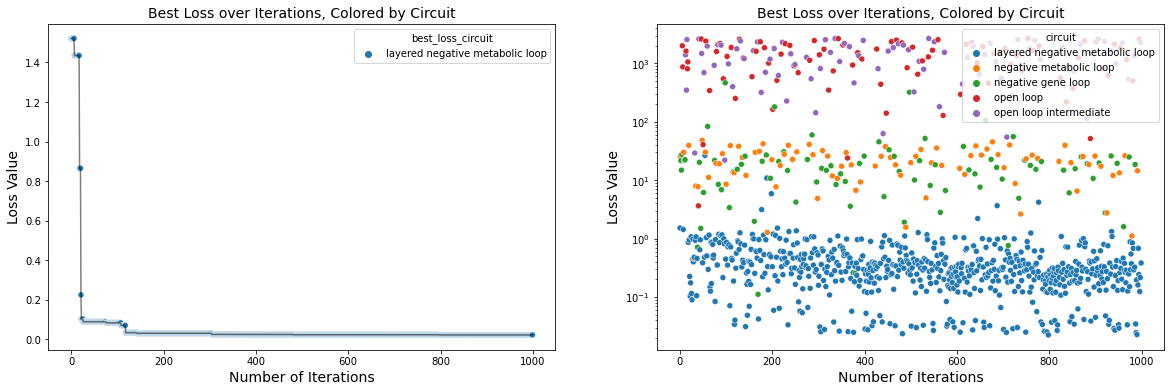

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
endpoint = 'Best Loss over Iterations, Colored by Circuit'

ax = axs[0]
ax.plot(best_losses, 'k-', alpha=0.5)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_ylabel('Loss Value', fontsize=14)
ax.set_xlabel('Number of Iterations', fontsize=14)
sns.scatterplot(range(len(landscape)), 'best_losses', hue='best_loss_circuit',data=landscape,  ax=ax)


ax = axs[1]
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_ylabel('Loss Value', fontsize=14)
ax.set_xlabel('Number of Iterations', fontsize=14)
ax.set_yscale('log')
sns.scatterplot(range(len(landscape)), 'loss', hue='circuit', data=landscape, ax=ax)
fig.savefig('fa_basic_1000.png')